In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import os
from xgboost import XGBClassifier

In [2]:
# Load the data
df = pd.read_csv('data/Protected_Processed.csv')

In [3]:
# Define features and target
#X = df.drop('loan_status', axis=1)
#y = df['loan_status']
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.3, random_state=42, stratify=y
#)

In [4]:
X_train = pd.read_csv('data/training/X_train_processed.csv')
X_test = pd.read_csv('data/training/X_test_processed.csv')
y_train = pd.read_csv('data/training/y_train_processed.csv')
y_test = pd.read_csv('data/training/y_test_processed.csv')

In [5]:
# Load fairness weights
weights = pd.read_csv('data/weights/fairness_weights_adjusted.csv')
sample_weights = weights.values.ravel()

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, sample_weights=None):
    """
    Train and evaluate model performance.
    
    Parameters:
    -----------
    model: The machine learning model to evaluate
    X_train, y_train: Training data
    X_test, y_test: Test data
    model_name: String name of the model for reporting
    sample_weights: Optional sample weights for training
    
    Returns:
    --------
    Dictionary of performance metrics and the trained model
    """
    # Start timer
    start_time = time.time()
    
    # Train model with or without weights
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
        weight_status = "Weighted"
    else:
        model.fit(X_train, y_train)
        weight_status = "Unweighted"
        
    # End timer
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scoring = 'roc_auc'
    cv_params = {'sample_weight': sample_weights} if sample_weights is not None else {}
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=cv_scoring,
                             fit_params=cv_params)
    
    # Print results
    print(f"\nModel: {model_name} ({weight_status})")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Class 1 - Precision: {report['1']['precision']:.4f}, " 
          f"Recall: {report['1']['recall']:.4f}, "
          f"F1: {report['1']['f1-score']:.4f}")
    
    
    # Store results for return
    result = {
        'Model': f"{model_name} ({weight_status})",
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'F1-Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'CV ROC AUC': cv_scores.mean(),
        'CV ROC AUC Std': cv_scores.std(),
        'Training Time': train_time
    }
    
    # Also return the FPR and TPR for ROC curve plotting
    return result, model, fpr, tpr
    
    return result, model

In [7]:
# Define models to evaluate
models = [
    (XGBClassifier(n_estimators=100, random_state=42), "XGBoost")
]

# Store results
results = []
trained_models = {}

In [8]:
# Evaluate XGBoost without weights
print("\n--- Training XGBoost WITHOUT weights ---")
unweighted_model = XGBClassifier(n_estimators=100, random_state=42)
unweighted_result, unweighted_trained, unweighted_fpr, unweighted_tpr = evaluate_model(
    unweighted_model, X_train, y_train, X_test, y_test, "XGBoost")
results.append(unweighted_result)
trained_models["XGBoost (Unweighted)"] = unweighted_trained


--- Training XGBoost WITHOUT weights ---

Model: XGBoost (Unweighted)
Training Time: 0.90 seconds
Accuracy: 0.8146
ROC AUC: 0.7509
PR AUC: 0.9074
CV ROC AUC: 0.7503 ± 0.0022
Class 1 - Precision: 0.8258, Recall: 0.9702, F1: 0.8922


In [17]:
# Save unweighted model
#joblib.dump(unweighted_trained, 'xgboost_model_unweighted.joblib')
print(f"Saved unweighted XGBoost model to 'xgboost_model_unweighted.joblib'")

Saved unweighted XGBoost model to 'xgboost_model_unweighted.joblib'


In [9]:
# Evaluate XGBoost with weights
print("\n--- Training XGBoost WITH weights ---")
weighted_model = XGBClassifier(n_estimators=100, random_state=42)
weighted_result, weighted_trained, weighted_fpr, weighted_tpr = evaluate_model(
    weighted_model, X_train, y_train, X_test, y_test, "XGBoost", sample_weights)
results.append(weighted_result)
trained_models["XGBoost (Weighted)"] = weighted_trained



--- Training XGBoost WITH weights ---

Model: XGBoost (Weighted)
Training Time: 0.72 seconds
Accuracy: 0.7032
ROC AUC: 0.7423
PR AUC: 0.9034
CV ROC AUC: 0.7425 ± 0.0027
Class 1 - Precision: 0.8801, Recall: 0.7232, F1: 0.7940


In [19]:
# Save weighted model
#joblib.dump(weighted_trained, 'xgboost_model_weighted.joblib')
print(f"Saved weighted XGBoost model to 'xgboost_model_weighted.joblib'")

Saved weighted XGBoost model to 'xgboost_model_weighted.joblib'



--- XGBoost Model Comparison (Weighted vs Unweighted) ---
                  Model  Accuracy   ROC AUC    PR AUC  F1-Score  Precision  \
0  XGBoost (Unweighted)  0.814565  0.750910  0.907357  0.892191   0.825775   
1    XGBoost (Weighted)  0.703176  0.742325  0.903406  0.793964   0.880142   

     Recall  CV ROC AUC  Training Time  
0  0.970226    0.750323       0.879976  
1  0.723157    0.742532       1.116176  

Model file sizes:
Unweighted model: 0.41 MB
Weighted model: 0.42 MB
Size difference: 0.01 MB


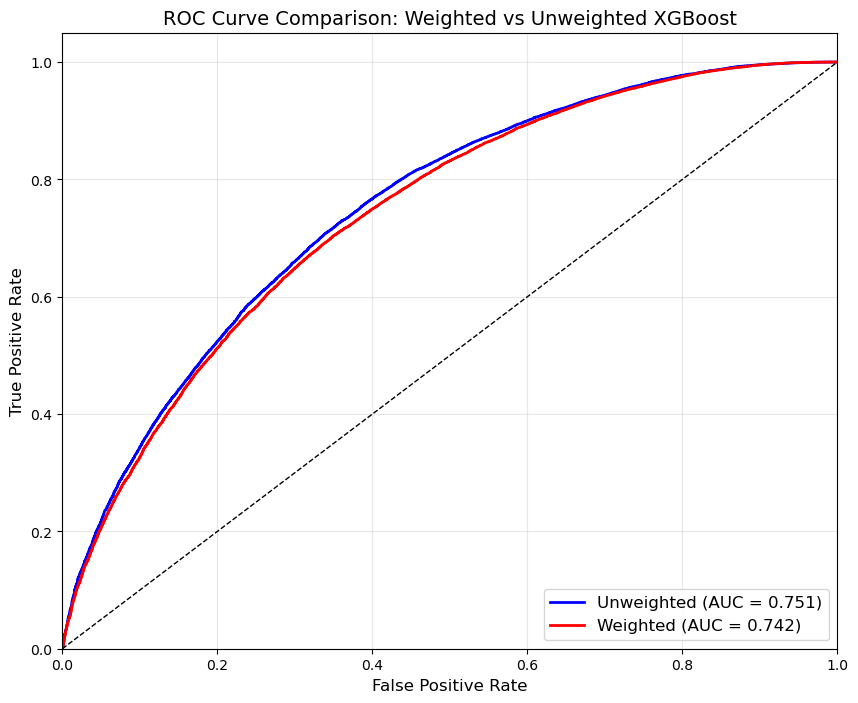

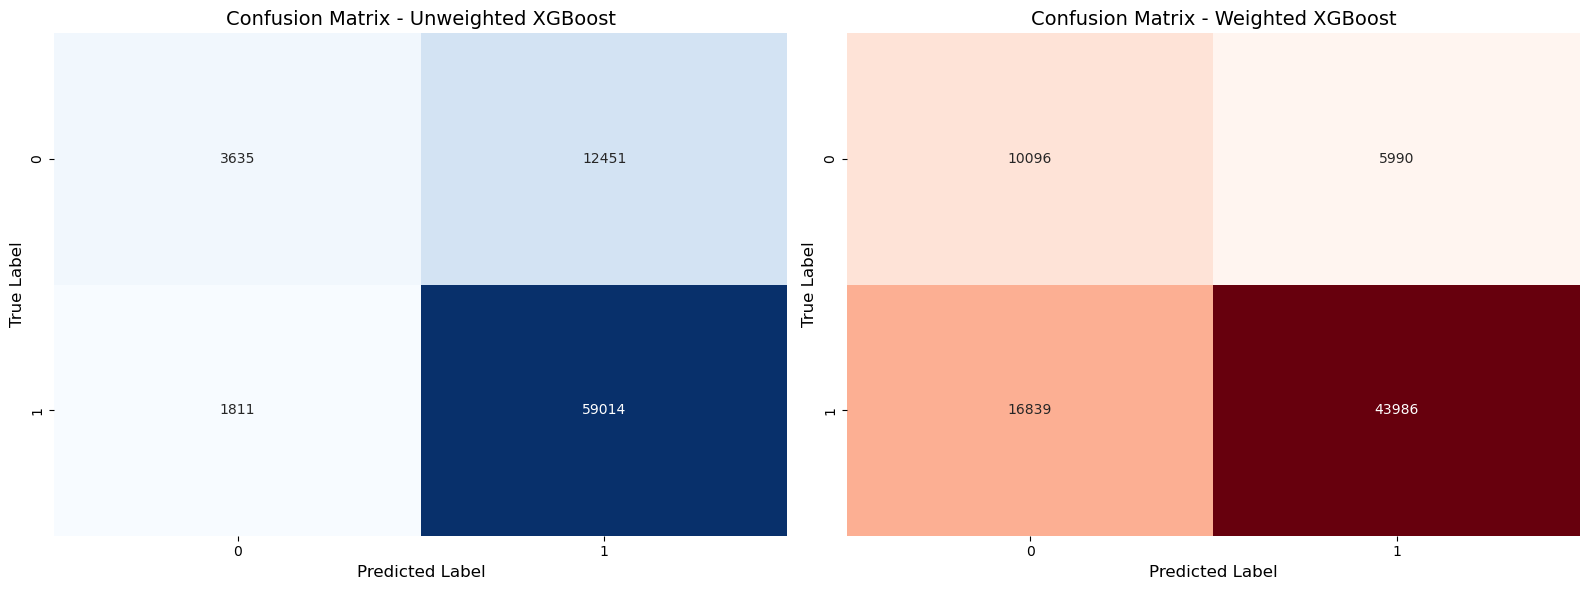

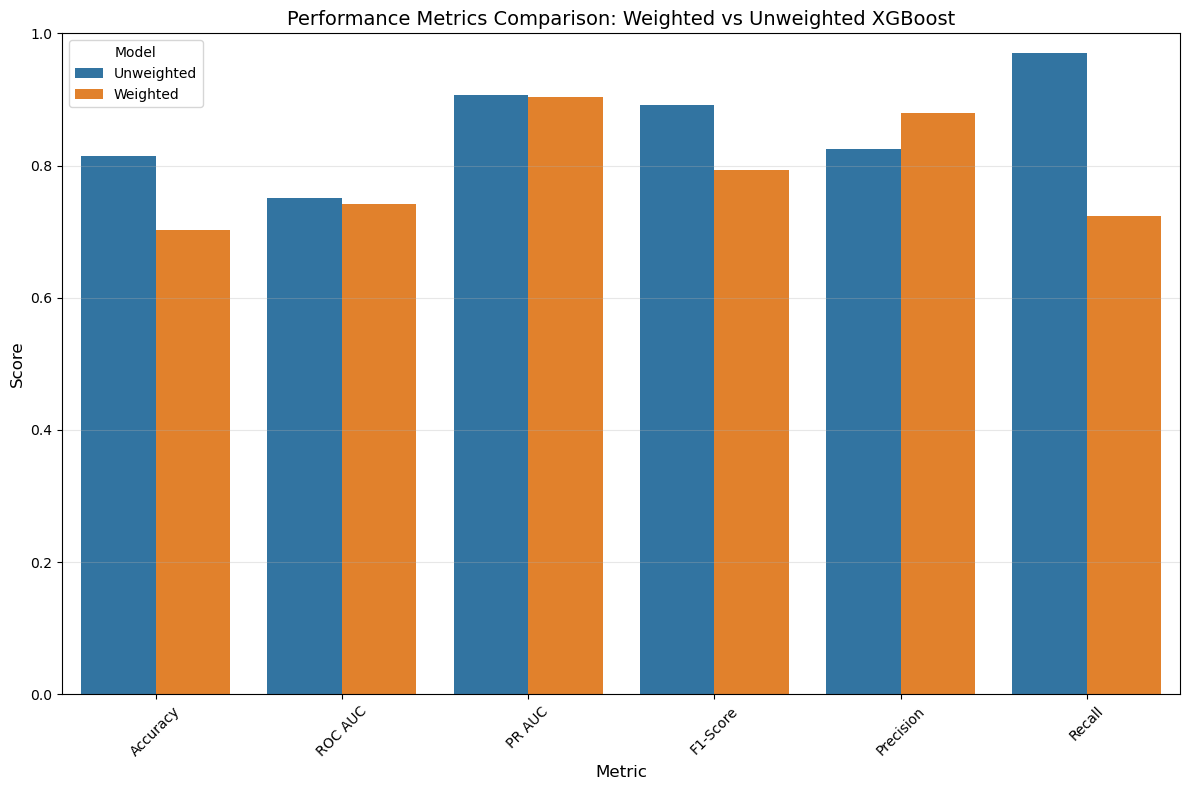

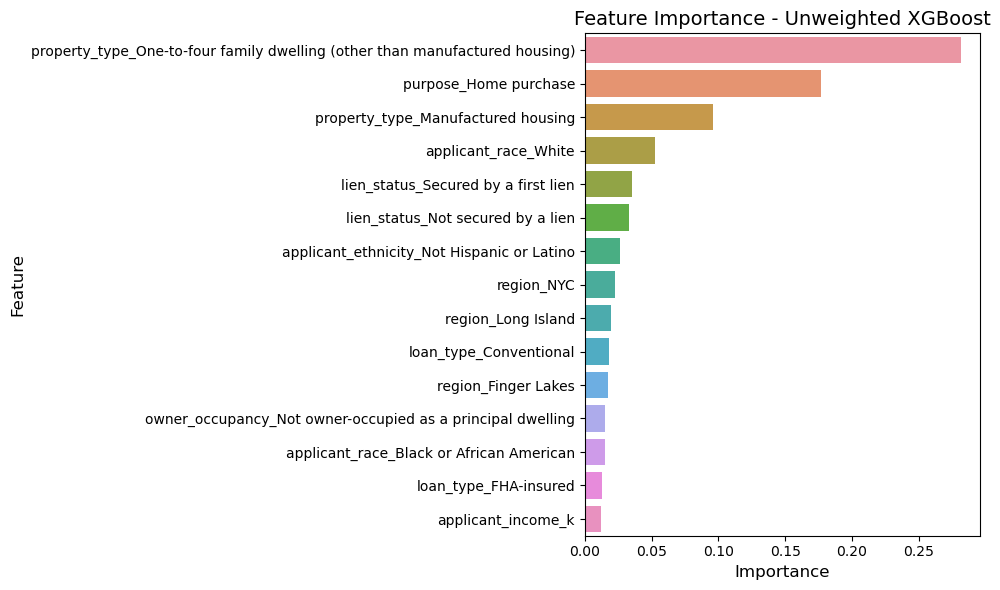

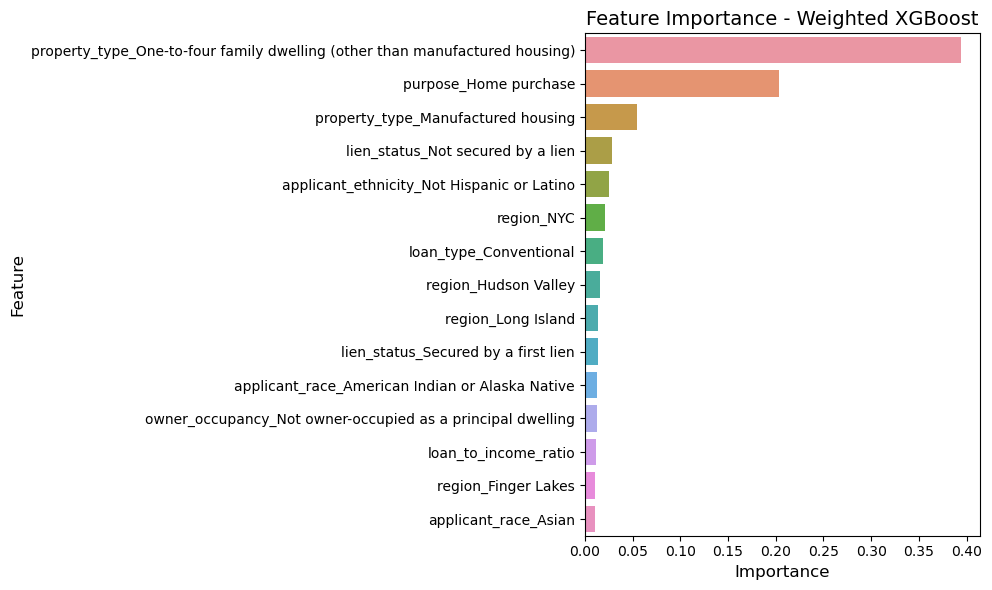

In [11]:


# Create DataFrame for side-by-side model comparison
results_df = pd.DataFrame(results)
comparison_metrics = ['Model', 'Accuracy', 'ROC AUC', 'PR AUC', 'F1-Score', 'Precision', 'Recall', 'CV ROC AUC', 'Training Time']
print("\n--- XGBoost Model Comparison (Weighted vs Unweighted) ---")
print(results_df[comparison_metrics])

# Print file sizes
if os.path.exists('Models/xgboost_model_unweighted.joblib') and os.path.exists('Models/xgboost_model_weighted.joblib'):
    unweighted_size = os.path.getsize('Models/xgboost_model_unweighted.joblib') / (1024 * 1024)  # Size in MB
    weighted_size = os.path.getsize('Models/xgboost_model_weighted.joblib') / (1024 * 1024)  # Size in MB
    print(f"\nModel file sizes:")
    print(f"Unweighted model: {unweighted_size:.2f} MB")
    print(f"Weighted model: {weighted_size:.2f} MB")
    print(f"Size difference: {abs(weighted_size - unweighted_size):.2f} MB")

# Plot ROC curves for visual comparison
plt.figure(figsize=(10, 8))
plt.plot(unweighted_fpr, unweighted_tpr, 
         label=f"Unweighted (AUC = {unweighted_result['ROC AUC']:.3f})", 
         color='blue', linewidth=2)
plt.plot(weighted_fpr, weighted_tpr, 
         label=f"Weighted (AUC = {weighted_result['ROC AUC']:.3f})", 
         color='red', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Weighted vs Unweighted XGBoost', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Unweighted confusion matrix
y_pred_unweighted = unweighted_trained.predict(X_test)
cm_unweighted = confusion_matrix(y_test, y_pred_unweighted)
sns.heatmap(cm_unweighted, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
ax1.set_title('Confusion Matrix - Unweighted XGBoost', fontsize=14)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Weighted confusion matrix
y_pred_weighted = weighted_trained.predict(X_test)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax2)
ax2.set_title('Confusion Matrix - Weighted XGBoost', fontsize=14)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Create a bar chart comparing key metrics
metrics_to_compare = ['Accuracy', 'ROC AUC', 'PR AUC', 'F1-Score', 'Precision', 'Recall']
comparison_data = {
    'Metric': metrics_to_compare,
    'Unweighted': [unweighted_result[metric] for metric in metrics_to_compare],
    'Weighted': [weighted_result[metric] for metric in metrics_to_compare]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.melt(id_vars=['Metric'], var_name='Model', value_name='Value')

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=comparison_df)
plt.title('Performance Metrics Comparison: Weighted vs Unweighted XGBoost', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance comparison
def plot_feature_importance(model, title):
    # Get feature importance
    importance = model.feature_importances_
    # Create DataFrame for plotting
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(title, fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot feature importances
plot_feature_importance(unweighted_trained, 'Feature Importance - Unweighted XGBoost')
plot_feature_importance(weighted_trained, 'Feature Importance - Weighted XGBoost')